In [1]:
# importing packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# load data + generate colors
seed = np.random.seed()
df = pd.read_csv('/Users/SnehPandya/Desktop/DeepLearningAGN/data/clean_full_data_absma2g.csv')
df = df.drop(columns = ['Mass_ground_truth','RA', 'DEC', 'ID', 'ERR', 'M_i','M_g','M_r','M_z', 'M_u', 'mu','Unnamed: 0'])
df['ug'] = df.apply(lambda row: row.u_band - row.g_band,axis=1)
df['gr'] = df.apply(lambda row: row.g_band - row.r_band,axis=1)
df['ri'] = df.apply(lambda row: row.r_band - row.i_band,axis=1)
df['iz'] = df.apply(lambda row: row.i_band - row.z_band,axis=1)
df['zu'] = df.apply(lambda row: row.z_band - row.u_band,axis=1)
df.head()

,u_band,g_band,r_band,i_band,z_band,z,ug,gr,ri,iz,zu
0,18.982250,18.900643,18.596375,18.584750,18.720857,1.1875,0.081607,0.304268,0.011625,-0.136107,-0.261393
1,20.822754,20.706984,20.583098,20.400262,20.097541,2.0993,0.115770,0.123885,0.182836,0.302721,-0.725213
2,21.185649,20.891439,20.409386,20.336351,20.082965,1.1103,0.294211,0.482053,0.073035,0.253386,-1.102684
3,20.238111,19.877519,19.916019,19.845519,19.731352,0.6794,0.360593,-0.038500,0.070500,0.114167,-0.506759
4,17.895957,17.664872,17.407213,17.446128,17.437894,1.0459,0.231085,0.257660,-0.038915,0.008234,-0.458064


In [3]:
# define feature and target numpy arrays, do train and test split, convert to tensors
X = df.iloc[:, 6:]
y = df.iloc[:,5]
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = seed)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train.to_numpy()).float()
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test.to_numpy()).float()

In [4]:
# define train and test dataset
train_ds = TensorDataset(X_train_t,y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

In [5]:
# define train data loader -- does dtype conversion
batch_size = 15
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(5, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x.float()))
#         x = F.relu(self.fc2(x.float()))
#         x = F.relu(self.fc3(x.float()))
        x = F.relu(self.fc4(x.float()))
        x = F.relu(self.fc5(x.float()))
        x = F.relu(self.fc6(x.float()))
        x = F.relu(self.fc7(x.float()))
        x = F.relu(self.fc8(x.float()))
        x = self.fc9(x.float())
        return x

net = Net()

In [13]:
# loss function and optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = F.smooth_l1_loss

In [16]:
# training loop
def train(num_epochs, model, loss_fn, optimizer):
    outputs_pred = []
    outputs_y = []
    outputs_loss = []
    epoch_list = np.linspace(1,num_epochs , num = num_epochs)
    
    for epoch in range(num_epochs): # full passes over the data
        
        for data in train_dl:  # `data` is a batch of data
            X, y = data  # X is the batch of features, y is the batch of targets.
            outputs_y.append(y.float())
            net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
            output = net(X)# pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), y)# calc and grab the loss value
            loss.backward()  # apply this loss backwards thru the network's parameters
            optimizer.step() # attempt to optimize weights to account for loss/gradients
            
        outputs_loss.append(loss.float())
        inputs = torch.cat(outputs_y).data # .stack for using dataset (.cat for dataloader)
        results = torch.cat(outputs_pred).data
        rmse = np.sqrt(metrics.mean_squared_error(inputs, results))
        plt.plot(inputs,inputs,color='black', label = 'Redshift Ground Truth')
        plt.scatter(inputs,results,s=2,color='blue', label = 'NN prediction',alpha=.5)
        print(loss)
        plt.title('EPOCH:' + str(epoch + 1) +'/'+ str(num_epochs) + ', RMSE:' + str(rmse))
        plt.xlabel('AGN Redshift')
        plt.ylabel('AGN Redshift')
        plt.legend()
        plt.show()
        
    plt.plot(epoch_list, outputs_loss,color='green')
    plt.xticks(epoch_list)
    plt.title('LOSS VS. # EPOCHS')
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.8570, grad_fn=<SmoothL1LossBackward>)


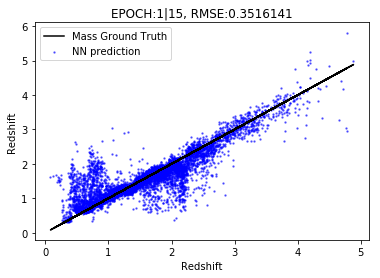

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.5107, grad_fn=<SmoothL1LossBackward>)


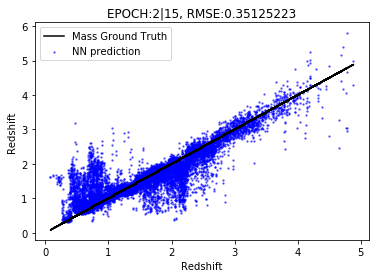

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0040, grad_fn=<SmoothL1LossBackward>)


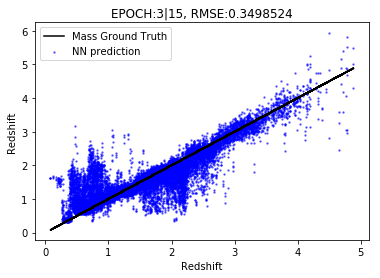

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.2658, grad_fn=<SmoothL1LossBackward>)


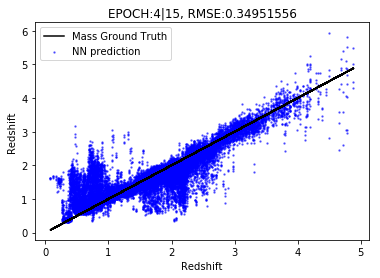

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0028, grad_fn=<SmoothL1LossBackward>)


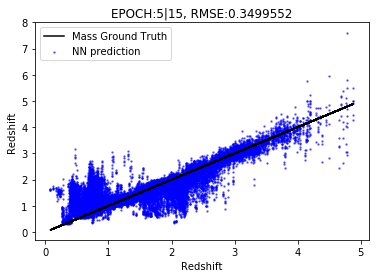

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0108, grad_fn=<SmoothL1LossBackward>)


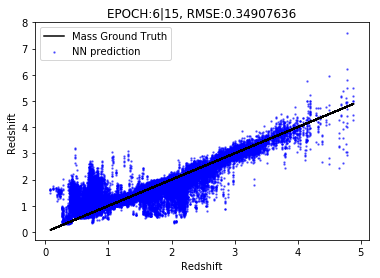

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0008, grad_fn=<SmoothL1LossBackward>)


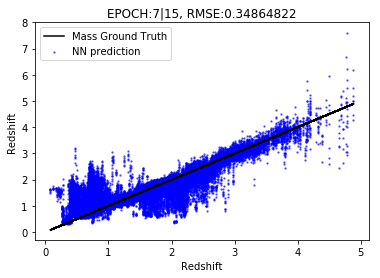

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0011, grad_fn=<SmoothL1LossBackward>)


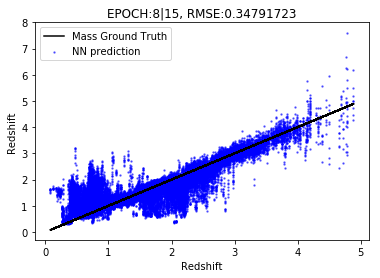

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0186, grad_fn=<SmoothL1LossBackward>)


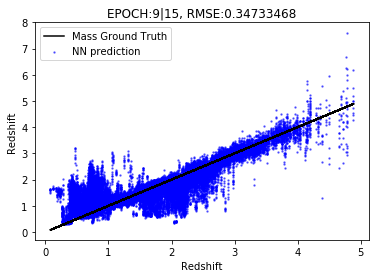

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0010, grad_fn=<SmoothL1LossBackward>)


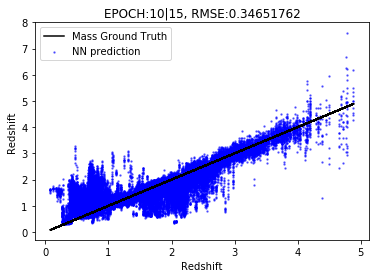

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0221, grad_fn=<SmoothL1LossBackward>)


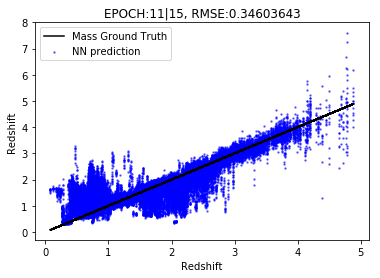

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0003, grad_fn=<SmoothL1LossBackward>)


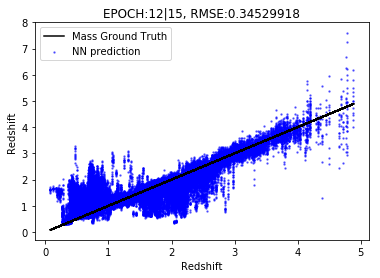

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(9.6808e-05, grad_fn=<SmoothL1LossBackward>)


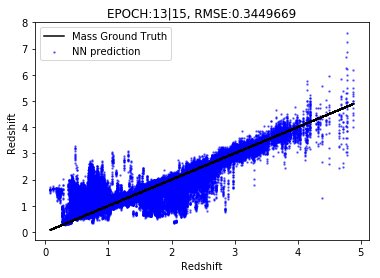

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0088, grad_fn=<SmoothL1LossBackward>)


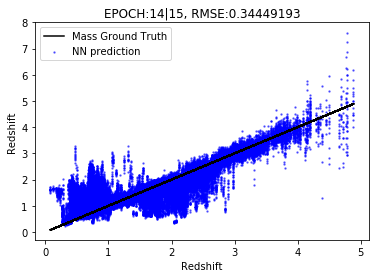

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  from ipykernel import kernelapp as app


tensor(0.0006, grad_fn=<SmoothL1LossBackward>)


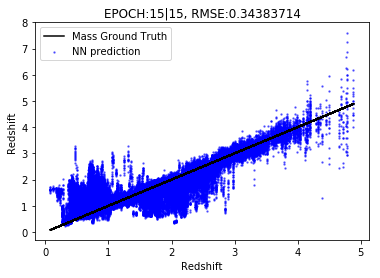

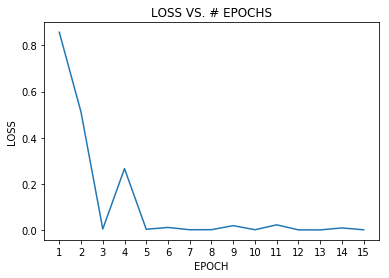

In [17]:
train(15, net, loss_function, optimizer)

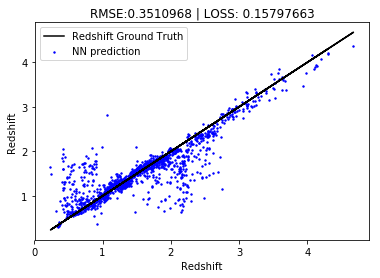

In [18]:
# testing loop
def test(net):
    
    with torch.no_grad():
        outputs_pred = []
        outputs_y = []
        
        for data in test_dl:
            X, y = data  # X is the batch of features, y is the batch of targets.
            outputs_y.append(y.float())
            output = net(X.float()) # pass in the reshaped batch (recall they are 28x28 atm)
            outputs_pred.append(output.float())
            loss = loss_function(output.squeeze(), y.float())# calc and grab the loss value
            
        inputs = torch.cat(outputs_y).data # .stack for using dataset (.cat for dataloader)
        results = torch.cat(outputs_pred).data
        rmse = np.sqrt(metrics.mean_squared_error(inputs, results))
        plt.plot(inputs,inputs,color='black', label = 'Redshift Ground Truth')
        plt.scatter(inputs,results,s=2,color='blue', label = 'NN prediction')
        plt.title('RMSE:' + str(rmse) + ' | LOSS: ' + str(loss.data.numpy()))
        plt.xlabel('Redshift')
        plt.ylabel('Redshift')
        plt.legend()
        plt.show()
        
test(net)

In [11]:
# 20 epochs, smooth l1 loss, batch size 32, rmse = .33648893
# 20 epochs, smooth l1 loss, batch size 10, rmse = .355931513
# 15,smooth,15, .351444204